#Install Open3D
3D data를 다루는 오픈소스 라이브러리 Open3D를 설치한다

In [41]:
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Library import
Python에서 벡터, 행렬 등 수치 연산을 수행하는 선형대수 라이브러리 Numpy<br/>
Point Cloud를 시각화하는 데 사용되는 라이브러리 Open3D<br/>
반응적인 그래프를 그릴 수 있는 라이브러리 Plotly<br/>
실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리 OpenCV<br/>
이미지 분석 및 처리를 쉽게 하는 라이브러리 PIL<br/><br/>

Google Drive와 Colaboratory 연결 및 마운트


In [42]:
import numpy as np
import open3d as o3d
import plotly.graph_objects as go
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
%cd /content/drive/MyDrive/3DDP23_HW2

/content/drive/MyDrive/3DDP23_HW2


#Calibration
Camera Parameter를 구하기 위해서 Calibration을 수행한다

In [44]:
# 파일들의 리스트를 뽑을 때 사용하는 glob
import glob

# 패턴(체커보드) 정보
# nH: x 방향 cross-corner 개수
# nV: y 방향 cross-corner 개수
# nSize: 정사각형의 한 변의 길이 (mm)
nH = 9
nV = 6
nSize = 19.17

# Images file list 저장
images = glob.glob('./captures/*.jpg')
# 체커보드 패턴의 가로와 세로 방향의 교차점 개수
CHECKERBOARD = (nV,nH)
# 체커보드 코너를 검출하는 데 사용되는 종료 기준
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# 각 체커보드 이미지에 대한 3D 점 벡터를 저장할 벡터 생성
objpoints = []

# 각 체커보드 이미지에 대한 2D 점 벡터를 저장할 벡터 생성
imgpoints = [] 

# 3D 점의 세계 좌표 정의
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) * nSize
prev_img_shape = None

# 이미지 파일들 순회
for fname in images:
    # 이미지 불러오기
    img = cv2.imread(fname)
    # 그레이스케일로 변환
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # 체커보드에서 코너 검출
    ret, corners = cv2.findChessboardCorners(gray,
                                             CHECKERBOARD,
                                             cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        imgpoints.append(corners2)
        # 체커보드 코너 시각화
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
    cv2_imshow(cv2.resize(img,  dsize=(0, 0), fx=0.4, fy=0.4, interpolation=cv2.INTER_LINEAR))

h,w = img.shape[:2]

# 알려진 3D 점(objpoints) 값과 감지된 코너의 해당 픽셀 좌표(imgpoints) 전달, 카메라 캘리브레이션 수행
# K = Intrinsic parameter(Camera matrix)
# dist = Distortion coefficients
# rvecs = Rotation vectors
# tvecs = Translation vectors
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


Output hidden; open in https://colab.research.google.com to view.

#Intrinsic matrix, Distortion coefficient, Rotation vectors,  Translation vectors 출력


In [45]:
# Intrinsic Parameter
print("K\n")
print(K)
print("\n")

# 렌즈 왜곡 계수(Lens Distortion coefficients)
print("dist\n")
print(dist)
print("\n")


# Make extrinsic parameter by approximation
# No rotation, Translation to x-axis only
rvecs = np.eye(3)
tvecs = np.array([1, 0, 0], dtype=float)

# Rotation vectors
print("rvecs\n")
print(rvecs)
print("\n")

# Translation vectors
print("tvecs\n")
print(tvecs)
print("\n")


K

[[763.89401666   0.         494.18222921]
 [  0.         763.03720468 369.47356131]
 [  0.           0.           1.        ]]


dist

[[ 2.63271379e-01 -1.42787786e+00  3.69569319e-04  3.54346515e-04
   2.24128246e+00]]


rvecs

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


tvecs

[1. 0. 0.]




#Rectification
Image의 모든 epipolar line들이 평행하고 동일한 y 값을 갖도록 한다

In [46]:
# Load the left and right images
left = cv2.imread('Left.png')
right = cv2.imread('Right.png')

# Compute the rectification transforms
# R1: 첫 번째 카메라의 rotation matrix
# R2: 두 번째 카메라의 rotation matrix
# P1: 첫 번째 카메라의 projection matrix
# P2: 두 번째 카메라의 projection matrix
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(K, dist, K, dist, (left.shape[1], left.shape[0]), rvecs, tvecs)

# Compute the rectification maps
map1x, map1y = cv2.initUndistortRectifyMap(K, dist, R1, P1, (left.shape[1], left.shape[0]), cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(K, dist, R2, P2, (right.shape[1], right.shape[0]), cv2.CV_32FC1)

# Rectify the images using the computed rectification maps
left_rectified = cv2.remap(left, map1x, map1y, cv2.INTER_LINEAR)
right_rectified = cv2.remap(right, map2x, map2y, cv2.INTER_LINEAR)

# Display the rectified images
cv2_imshow(left_rectified)
cv2_imshow(right_rectified)


Output hidden; open in https://colab.research.google.com to view.

#Stereo Matching
스테레오 이미지 쌍에서 Disparity를 계산한다<br/>
Disparity를 계산하기 위한 알고리즘으로 cv2.StereoBM을 사용한다

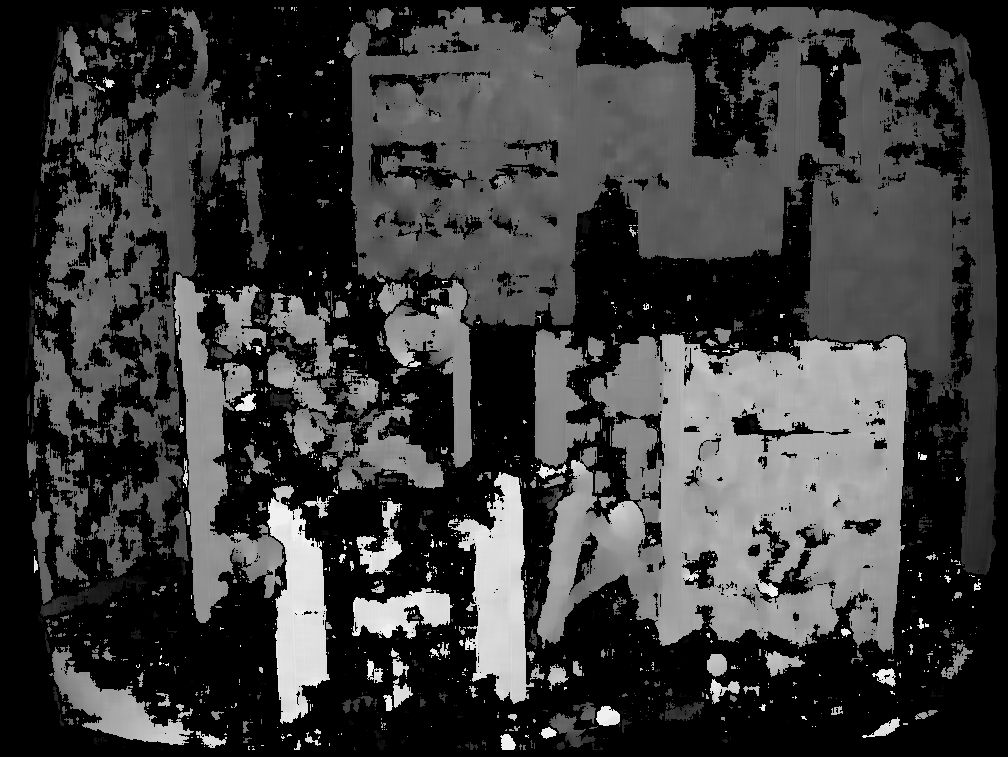

In [47]:
# Convert rectifed images to grayscale
left_gray = cv2.cvtColor(left_rectified,cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_rectified,cv2.COLOR_BGR2GRAY)

# Create a StereoBM instance
# numDisparities: Maximum distance
# blockSize: Template size
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

# Compute the disparity map for display
disparity = stereo.compute(left_gray, right_gray)
cv2_imshow(disparity)


#Generate Point Clouds
왼쪽 이미지에서 아래 조건을 만족하지 않는 모든 픽셀에 대해서 3D 위치를 구한다
- Disparity less than 0
- Pixel RGB value is [0,0,0]
- Z is more farther than threshold

In [48]:
# Left image의 높이, 너비 및 채널 수
h, w, ch = left.shape
# 색상 정보와 3D 점을 저장하기 위한 빈 리스트 생성
colors = []
points = []

# Focal Length
f_x = K[0,0]
f_y = K[1,1]
# Principal Point
c_x = K[0,2]
c_y = K[1,2]

# Baseline
B = 2
# Focal Length mean
f = (f_x + f_y) / 2

# Pont cloud를 생성할 때 사용할 픽셀 샘플링 비율 설정
sampling_rate = 10

for v in range(0,h,sampling_rate):
  for u in range(0,w,sampling_rate):
    color = left[int(v),int(u),:]
    # Disparity가 0인 것은 제외
    if (disparity[v, u] > 0):
      # B, f, disparity 값을 사용해서 Z를 계산
      Z = B * f / disparity[v, u]
      # 색상 정보가 있는 경우와 일정 깊이 범위 내에 있는 점만 저장
      if (color.any() and Z <= 20):
        X = (u - c_x) * Z / f_x
        Y = (v - c_y) * Z / f_y
        points.append([X,Y,Z])
        colors.append([color[2]/255.0,color[1]/255.0,color[0]/255.0])

# 리스트를 NumPy 배열로 변환
points=np.array(points)
colors=np.array(colors)

# Convert to Open3D.PointCLoud
# create a point cloud object
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(points)
pcd_o3d.colors=o3d.utility.Vector3dVector(colors)


#3D Visualization
Google Colab에서 o3d.visualization.draw_geometries() 함수는 작동하지 않는다<br/>
따라서 colab에서 사용할 수 있도록 함수를 새로 만들어서 대체한다

In [49]:
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()
        
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)
            
            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)
        
    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()
o3d.visualization.draw_geometries = draw_geometries # replace function


In [50]:
o3d.visualization.draw_geometries([pcd_o3d])